# 0.0. Imports

In [83]:
import re
import sqlite3
import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from sqlalchemy    import create_engine
from scipy.cluster import hierarchy     as hc
from plotly        import express       as px
from matplotlib    import pyplot        as plt
from sklearn       import cluster       as c
from sklearn       import metrics       as m
from sklearn       import ensemble      as en
from sklearn       import preprocessing as pp
from sklearn       import decomposition as dd
from sklearn       import manifold      as mn
from sklearn       import mixture       as mx

## 0.2. Load dataset

In [86]:
pwd


'/Users/anaotavio/Documents/repos/insiders_clustering/notebook'

In [87]:
# load data
path = '/Users/anaotavio/Documents/repos/insiders_clustering/'
df_raw = pd.read_csv(path + 'data/Ecommerce.csv')

# drop extra column
df_raw = df_raw.drop(columns = ['Unnamed: 8'], axis = 1)

# 1.0. Data Description

In [3]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [5]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3. Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [8]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [9]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how= 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)
   
df1.head()    


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [10]:
# No NaN in 'customer_id'
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [11]:
# invoice_date
df1["invoice_date"] = pd.to_datetime(df1["invoice_date"],infer_datetime_format=True)

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include =['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [13]:
 # central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2. Categorical Attributes

#### Invoice number

In [14]:
#cat_attributes['invoice_no'].astype(int)  -> Data contains 'invoice_no' with numbers and letters.
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x ))), :]
len(df_letter_invoices)

print('Total number of invoices:{}'.format(len(df_letter_invoices)))
print('Total number os negative quantity:{}'.format(len(df_letter_invoices[df_letter_invoices['quantity']< 0])))

Total number of invoices:9291
Total number os negative quantity:9288


#### Stock Code

In [15]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Action:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [16]:
# Action: Delete description

#### Country

In [17]:
len(df1['country'].unique())

38

In [18]:
df1['country'].value_counts(normalize = True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [19]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. Data Filtering

In [20]:
df2 = df1.copy()

In [21]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users - outlier
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchase = df2.loc[df1['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [22]:
df3 = df2.copy()

## 3.1. Feature Creation

In [23]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'],
                   axis =1 ).drop_duplicates( ignore_index = True)

In [24]:
df_ref.shape

(5786, 1)

### 3.1.1. Gross Revenue

In [25]:
# Gross Revenue
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']

# Monetary
df_monetary = df2_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')
df_ref.isna().sum()

/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [26]:
 # Recency - Last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

###  3.1.5. Quantity of products purchased

In [27]:
df_freq = (df2_purchase.loc[:,['customer_id', 'stock_code']].groupby('customer_id')
                                                        .count()
                                                        .reset_index()
                                                        .rename(columns={'stock_code': 'quantity_products'}))
                                                        
                                                        
df_ref = pd.merge( df_ref, df_freq, on = 'customer_id', how ='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_products    91
dtype: int64

### 3.1.8. Frequency Purchase

In [28]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_products    91
frequency            91
dtype: int64

### 3.1.9. Number of Returns

In [29]:
df2_returns.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
154,C536383,35004C,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,-24,2016-11-29,0.29,United Kingdom,17548
238,C536391,21980,-24,2016-11-29,0.29,United Kingdom,17548


In [30]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'quantity_returns'} )
df_returns['quantity_returns'] = df_returns['quantity_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['quantity_returns'].isna(), 'quantity_returns'] = 0

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_products    91
frequency            91
quantity_returns      0
dtype: int64

# 4.0. Exploratory Data Analysis (EDA)

In [31]:
df4 = df_ref.dropna()

In [32]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'quantity_products', 'frequency', 'quantity_returns']
df43 = df4[cols_selected].drop(columns='customer_id', axis=1)

In [33]:
df43.head()

,gross_revenue,recency_days,quantity_products,frequency,quantity_returns
0,5391.21,372.0,297.0,17.000000,40.0
1,3232.59,56.0,171.0,0.028302,35.0
2,6705.38,2.0,232.0,0.040323,50.0
3,948.25,95.0,28.0,0.017921,0.0
4,876.00,333.0,3.0,0.073171,22.0


## 4.3 Space Study

In [34]:
 # selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'quantity_products', 'frequency', 'quantity_returns']
df43 = df4[ cols_selected ].drop( columns='customer_id', axis=1 )

In [35]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']           = mm.fit_transform(df43[['recency_days']])
df43['quantity_products']      = mm.fit_transform(df43[['quantity_products']])
df43['frequency']              = mm.fit_transform(df43[['frequency']])
df43['quantity_returns']       = mm.fit_transform(df43[['quantity_returns']])
X = df43.copy()

### 4.3.1. PCA


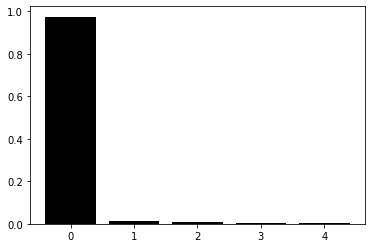

In [36]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

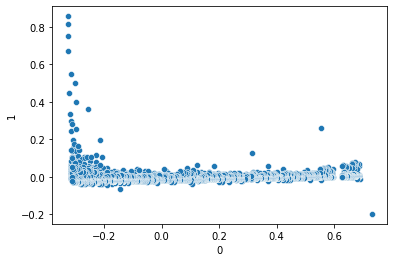

In [37]:
sns.scatterplot( x=0, y=1, data=df_pca )

###  4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

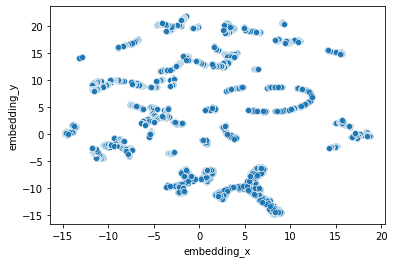

In [38]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap )

### 4.3.3. t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

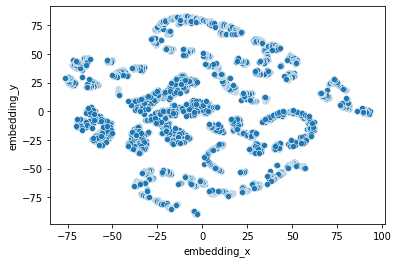

In [39]:
 reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne )

### 4.3.4. Tree-Based Embedding

In [40]:
# training dataset
X = df43.drop( columns=['gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 
df_leaf = pd.DataFrame( rf_model.apply( X ) )

/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

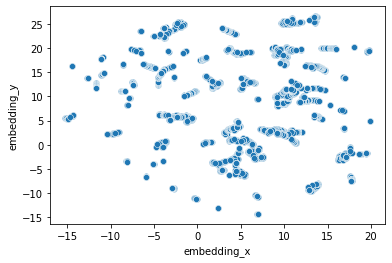

In [41]:
 # Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

#   5.0. Data Preparation

In [43]:
# Tree-Based Embedding
df5 = df_tree.copy()
df5.to_csv('tree_based_embedding.cdv')

# UMAP Embedding
#df5 = df_umap.copy()

# TSNE Embedding
#df5 = df_tsne.copy()

# 7.0. Hyperparameter Fine Tunning

In [44]:
X = df5.copy()

In [45]:
X.head()

,embedding_x,embedding_y
0,3.736267,-3.220681
1,7.023769,-2.743365
2,4.158807,-2.681693
3,13.134467,-8.960883
4,-8.535720,16.597038


In [46]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1. K-Means

In [47]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k, n_init=100, random_state=42 )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

Text(0.5, 1.0, 'Silhouette Score x K')

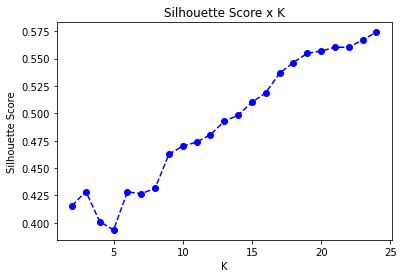

In [48]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K')

##  7.2. GMM

In [49]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k, n_init=10, random_state=42 )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

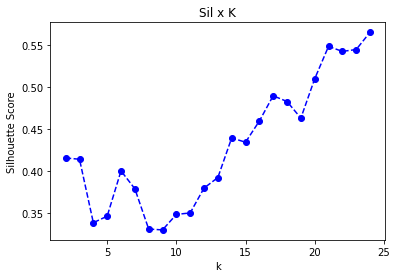

In [50]:
 plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [51]:
 # model definition and training
hc_model = hc.linkage( X, 'ward' )

###  7.3.1. HClustering Silhouette Score

In [52]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

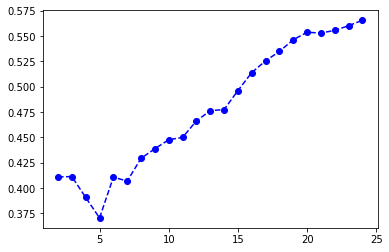

In [53]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

In [54]:
## 7.5. Results - Tree Based Embedding

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.415729,0.428559,0.401135,0.393502,0.428187,0.426653,0.431322,0.462600,0.469980,0.473712,0.480374,0.492620,0.498221,0.510003,0.518697,0.536505,0.546346,0.554769,0.556751,0.560359,0.560282,0.566934,0.574007
GMM,0.415661,0.414148,0.338358,0.346173,0.400231,0.378915,0.330823,0.329757,0.348260,0.350053,0.379694,0.392263,0.439578,0.434469,0.459753,0.489959,0.483066,0.463250,0.510170,0.548913,0.542900,0.545147,0.565781
HC,0.410910,0.411235,0.390614,0.370469,0.410723,0.406765,0.429285,0.438747,0.447596,0.449915,0.466145,0.476238,0.477379,0.496064,0.513824,0.525450,0.534723,0.546276,0.553617,0.552892,0.555546,0.560094,0.565506


# 8.0. Model Training

## 8.1. Final Model

In [55]:
 ## model definition
k = 9
kmeans = c.KMeans( init='random', n_clusters=k, random_state=42  )
#
## model training
kmeans.fit( X )
#
## clustering
labels = kmeans.labels_

In [56]:
labels

array([1, 0, 1, ..., 4, 4, 4], dtype=int32)

## 8.2. Cluster Validation

In [57]:
# SS (Silhouette Score)
print('SS value: {}'.format (m.silhouette_score(X, labels, metric='euclidean')))

SS value: 0.4538723826408386


# 9.0. Cluster Analysis

## 9.1. Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

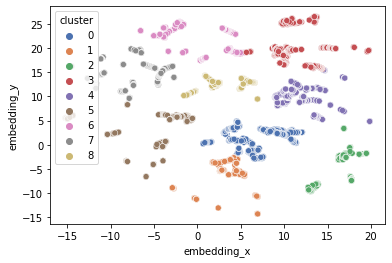

In [59]:
df9 = X.copy()
df9['cluster'] = labels
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## 9.2. Cluster Profile

In [60]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

# change dtypes
df92['recency_days'] = df92['recency_days'].astype(int)
df92['quantity_products'] = df92['quantity_products'].astype(int)
df92['quantity_returns'] = df92['quantity_returns'].astype(int)

In [61]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

# Avg gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how = 'inner', on ='cluster')

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how = 'inner', on ='cluster')

# Quantity Products
df_avg_quantity_products = df92[['quantity_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_quantity_products, how = 'inner', on ='cluster')

# Frequency
df_avg_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how = 'inner', on ='cluster')

# Quantity Returns
df_avg_quantity_returns = df92[['quantity_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_quantity_returns, how = 'inner', on ='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,quantity_products,frequency,quantity_returns
0,0,1063,18.665496,2448.618081,73.834431,167.054563,0.321776,10.876764
1,1,495,8.691835,8311.144384,77.143434,399.769697,0.369529,289.838384
2,2,429,7.532924,1039.901655,76.874126,56.720280,0.133748,4.090909
3,3,829,14.556629,678.087660,130.266586,32.053076,0.583568,5.570567
4,4,714,12.537313,993.200714,160.959384,30.882353,0.962599,6.331933
5,5,632,11.097454,1491.713085,114.318038,74.799051,0.400877,9.411392
6,6,614,10.781387,428.006417,107.506515,13.482085,0.532917,1.565147
7,7,501,8.797191,265.294192,170.455090,6.353293,0.702228,7.291417
8,8,418,7.339772,794.000167,166.698565,48.461722,1.031235,3.791866


**Cluster 1: Insiders**

**Cluster 0: More Products**

**Cluster 5: Spend Money**

**Cluster 2: Even More Products**

**Cluster 4: Spend More Money**

**Cluster 8: Less Days**

**Cluster 3: Less 1k**

**Cluster 6: Stop Returners**

**Cluster 7: More Buy**


# 11.0. Deploy to Production

In [63]:
df92.dtypes

customer_id            int64
gross_revenue        float64
recency_days           int64
quantity_products      int64
frequency            float64
quantity_returns       int64
cluster                int32
dtype: object

In [64]:
df92.shape

(5695, 7)

## 11.1. Insert into SQLITE

In [79]:
# database connection
conn = create_engine('sqlite:///insiders_db.sqlite')

# drop table
query_drop_insiders = """
    DROP TABLE insiders
"""     




In [80]:
# create table
query_create_insiders = """
    CREATE TABLE insiders (
        customer_id        INTEGER,
        gross_revenue      REAL,
        recency_days       INTEGER,
        quantity_products  INTEGER,
        frequency          REAL,
        quantity_returns   INTEGER,
        cluster            INTEGER
    )
"""

conn.execute( query_create_insiders)

In [81]:
# insert data into
df92.to_sql( 'insiders', con=conn, if_exists='append', index=False )

In [82]:
# consulting database
query = """
    SELECT * FROM insiders
"""

df = pd.read_sql_query(query, conn)

In [85]:
df.head()

,customer_id,gross_revenue,recency_days,quantity_products,frequency,quantity_returns,cluster
0,17850,5391.21,372,297,17.000000,40,1
1,13047,3232.59,56,171,0.028302,35,0
2,12583,6705.38,2,232,0.040323,50,1
3,13748,948.25,95,28,0.017921,0,2
4,15100,876.00,333,3,0.073171,22,7
